In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import sys
import matplotlib.pyplot as plt


import tensorflow_hub as hub


from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
DATA_DIR = "../input/food41/images"

TRAIN_DATA_DIR = "../input/food11-image-dataset/training"
TEST_DATA_DIR = "../input/food11-image-dataset/validation"

BATCH_SIZE = 32
SPLIT_SIZE = 0.3


OUTPUT_FIGURE_DIR = "./"

In [9]:
def train_val_generators(TRAIN_DIR, TEST_DIR, NUM_BATCHES):
    """

    :param DATA_DIR: Directory of the datasets was taken from (string)
    :param SPLIT_SIZE: Split size of test set. (float)
    :param NUM_BATCHES: Amount of batch size
    :return:
    """
    train_datagen = ImageDataGenerator(rescale=1/ 255.,
                                 rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    val_datagen = ImageDataGenerator(rescale=1/255.)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                  batch_size=NUM_BATCHES,
                                                  class_mode='categorical',
                                                  target_size=(224, 224),
                                                    shuffle = True,

    )

    validation_generator = val_datagen.flow_from_directory(directory=TEST_DIR,
                                                       batch_size=NUM_BATCHES,
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       target_size=(224, 224))

    return train_generator,validation_generator

In [10]:
train_ds, test_ds = train_val_generators(TRAIN_DATA_DIR, TEST_DATA_DIR, BATCH_SIZE)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [11]:
OPTIMIZER = 'adam'
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']

In [12]:
def plot_accuracy(history, output_dir, model_name):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/accuracy_{model_name}")
    plt.show()
    
def plot_loss(history, output_dir, model_name):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/loss_{model_name}")
    plt.show()

In [13]:
pre_trained_model_inception = tf.keras.applications.inception_v3.InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet',
                                             )

# Load the pre-trained weights you downloaded.
# pre_trained_model_inception.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model_inception.layers:
    layer.trainable = False
    
last_layer = pre_trained_model_inception.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [17]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dropout(0.2)(x)   
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (11, activation='softmax')(x)           

# Append the dense network to the base model
model_inception_1 = Model(pre_trained_model_inception.input, x) 

model_inception_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [18]:
# creating learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-4 * 10**(epoch/20))


model_inception_1.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
csv_logger = tf.keras.callbacks.CSVLogger("./LOG_CSV_INCEPTION_EXP1_20epoch.log")

In [19]:
history_model_inception_1 = model_inception_1.fit(train_ds, epochs=20, validation_data=test_ds, callbacks=[lr_scheduler,csv_logger])

Epoch 1/20
309/309 [==============================] - 214s 685ms/step - loss: 1.0574 - accuracy: 0.6423 - val_loss: 0.6571 - val_accuracy: 0.7831
Epoch 2/20
309/309 [==============================] - 173s 561ms/step - loss: 0.7572 - accuracy: 0.7434 - val_loss: 0.5987 - val_accuracy: 0.7994
Epoch 3/20
309/309 [==============================] - 174s 563ms/step - loss: 0.6812 - accuracy: 0.7672 - val_loss: 0.5352 - val_accuracy: 0.8294
Epoch 4/20
309/309 [==============================] - 174s 562ms/step - loss: 0.6202 - accuracy: 0.7875 - val_loss: 0.5353 - val_accuracy: 0.8222
Epoch 5/20
309/309 [==============================] - 174s 564ms/step - loss: 0.6085 - accuracy: 0.7871 - val_loss: 0.5468 - val_accuracy: 0.8201
Epoch 6/20
309/309 [==============================] - 175s 565ms/step - loss: 0.5858 - accuracy: 0.8031 - val_loss: 0.5762 - val_accuracy: 0.8117
Epoch 7/20
309/309 [==============================] - 174s 564ms/step - loss: 0.5722 - accuracy: 0.8041 - val_loss: 0.5697 -

Text(0.5, 1.0, 'Model Inception Exp 1')

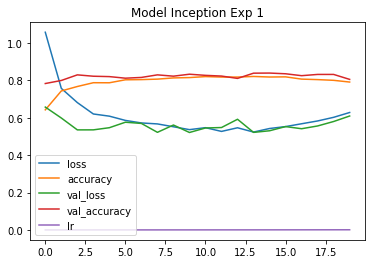

In [20]:
pd.DataFrame(history_model_inception_1.history).plot()
plt.title("Model Inception Exp 1")

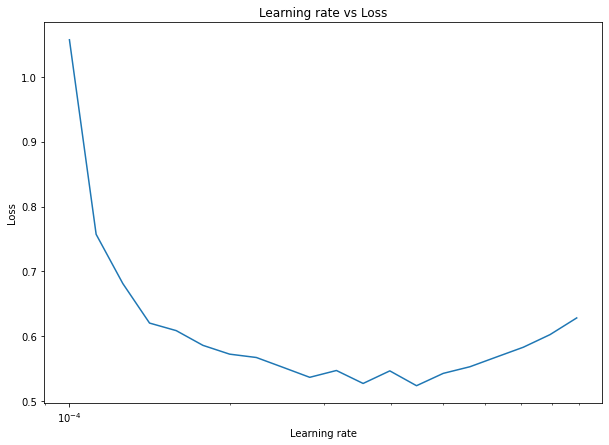

In [22]:
lrs = 1e-4 * (10 ** (tf.range(20) / 20))

plt.figure(figsize=(10,7))
plt.semilogx(lrs, history_model_inception_1.history['loss'])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Learning rate vs Loss")
plt.savefig(f"./history_model_inception_1")
plt.show()

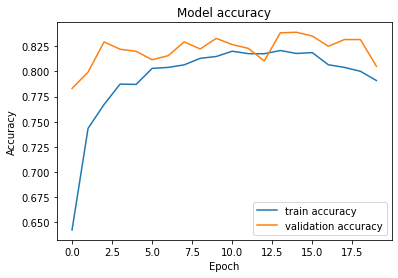

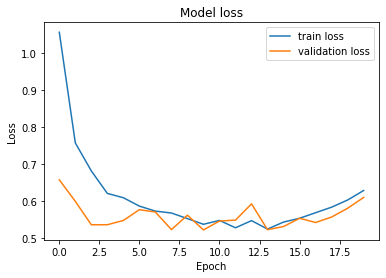

In [23]:
  
plot_accuracy(history_model_inception_1,".", 'model_inception_1_20epoch_accuracy')
plot_loss(history_model_inception_1, ".", 'model_inception_1_20epoch_loss')


# ResNetV250: 20 Epochs


In [27]:
ResNet_V2_50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'
model_ResNet_1 = tf.keras.Sequential([
    hub.KerasLayer(ResNet_V2_50, trainable = False, input_shape = (224,224,3), name = 'Resnet_V2_50'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),   
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(11, activation = 'softmax', name = 'Output_layer')
])



model_ResNet_1.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [28]:
# creating learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-4 * 10**(epoch/20))


model_ResNet_1.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

csv_logger = tf.keras.callbacks.CSVLogger("LOG_CSV_RESNET_EXP1_20epoch.log")

In [29]:
history_model_resnet_1 = model_ResNet_1.fit(train_ds, epochs=20,validation_data=test_ds, callbacks=[lr_scheduler,csv_logger])

Epoch 1/20
309/309 [==============================] - 179s 570ms/step - loss: 1.3240 - accuracy: 0.5921 - val_loss: 0.7198 - val_accuracy: 0.7638
Epoch 2/20
309/309 [==============================] - 174s 564ms/step - loss: 0.8888 - accuracy: 0.7204 - val_loss: 0.6400 - val_accuracy: 0.7869
Epoch 3/20
309/309 [==============================] - 174s 565ms/step - loss: 0.7843 - accuracy: 0.7448 - val_loss: 0.5903 - val_accuracy: 0.8052
Epoch 4/20
309/309 [==============================] - 174s 564ms/step - loss: 0.6942 - accuracy: 0.7726 - val_loss: 0.5770 - val_accuracy: 0.8131
Epoch 5/20
309/309 [==============================] - 173s 559ms/step - loss: 0.6531 - accuracy: 0.7805 - val_loss: 0.5758 - val_accuracy: 0.8149
Epoch 6/20
309/309 [==============================] - 174s 562ms/step - loss: 0.6313 - accuracy: 0.7880 - val_loss: 0.5508 - val_accuracy: 0.8198
Epoch 7/20
309/309 [==============================] - 174s 562ms/step - loss: 0.5946 - accuracy: 0.7997 - val_loss: 0.5548 -

Text(0.5, 1.0, 'Model Inception Exp 1')

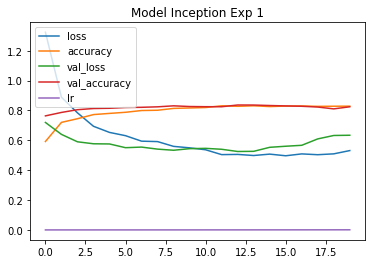

In [30]:
pd.DataFrame(history_model_resnet_1.history).plot()
plt.title("Model Inception Exp 1")

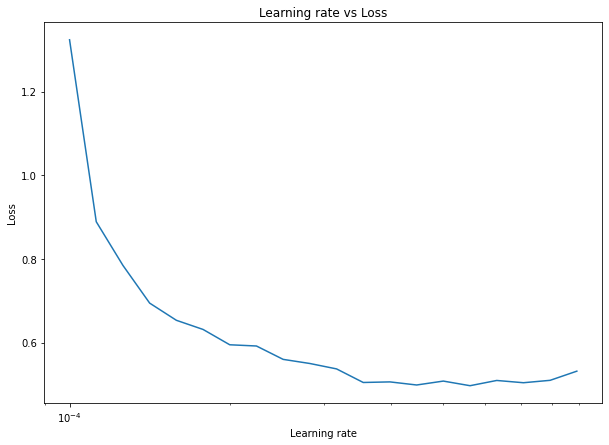

In [31]:
lrs = 1e-4 * (10 ** (tf.range(20) / 20))

plt.figure(figsize=(10,7))
plt.semilogx(lrs, history_model_resnet_1.history['loss'])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Learning rate vs Loss")
plt.savefig(f"./history_model_resnet_1")
plt.show()

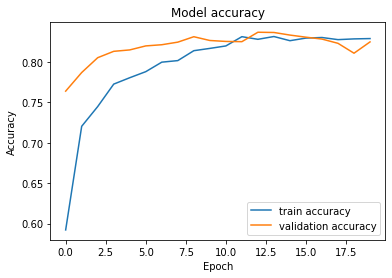

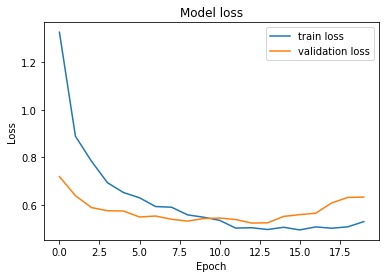

In [32]:
  
plot_accuracy(history_model_resnet_1,".", 'model_resnet_1_20epoch_accuracy')
plot_loss(history_model_resnet_1, ".", 'model_resnet_1_20epoch_loss')
